# Evaluation of Learned Decoder
The purpose of this notebook is to evaluate the effectiveness of the learned decoders from CNN and GAN

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torchvision
import torchvision.transforms as transforms
import torch
from torch.utils.data import DataLoader

import wandb
import datetime
desktop_path = '/Users/jornelasmunoz/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/'
laptop_path = '/Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/'
if desktop_path in sys.path[0]: sys.path.insert(0, desktop_path + 'lib/'); path = desktop_path
elif laptop_path in sys.path[0]: sys.path.insert(0, laptop_path + 'lib/'); path = laptop_path
print('Using path = ', path)

from dataset import MNIST_MURA
from utils import Noise_dB, Normalize_01

# # Change plotting parameters
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "Times", #"Computer Modern Serif"
#     "figure.figsize" : [15,10],
# })

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Log into WandB
# wandb.login()

Using path =  /Users/jornelasmunoz/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/
Using cpu device


In [3]:
# Log into WandB for logging project training runs
wandb.login()

wandb: Currently logged in as: jocelynornelasmunoz. Use `wandb login --relogin` to force relogin


True

In [4]:
# Create params dict
date = '2024-01-11'#str(datetime.datetime.now().date())
params = {
    "image_size": 23,
    "batch_size":100,
    "learning_rate": 0.001, 
    "epochs": 10,
    "model": f"decoder_cnn_{date}",
    "dataset": "mnist_mura_noiseless",
    "scheduler_patience": 2,
    "snr": None, 
}
wandb.config = params

In [5]:
# Define transforms
transform_list = transforms.Compose(
            [   transforms.Grayscale(),
                transforms.ToTensor(),
                transforms.Resize(params['image_size'], antialias=True),
                # Noise_dB(desired_snr=params['snr']),
                # transforms.Normalize(0, 1),
                Normalize_01(),
                ])
target_transform = transforms.Compose(
            [   transforms.Grayscale(),
                transforms.ToTensor(),
                transforms.Resize((params['image_size'],params['image_size']), antialias=True),
                Normalize_01(),
                ])

In [6]:
# Load dataset
mnist_mura = MNIST_MURA('../data/MNIST/', params, transform=transform_list, target_transform=target_transform, train=True)

loaders = {}
# Define DataLoader
loaders['train'] = DataLoader(mnist_mura, batch_size=1, shuffle=False)

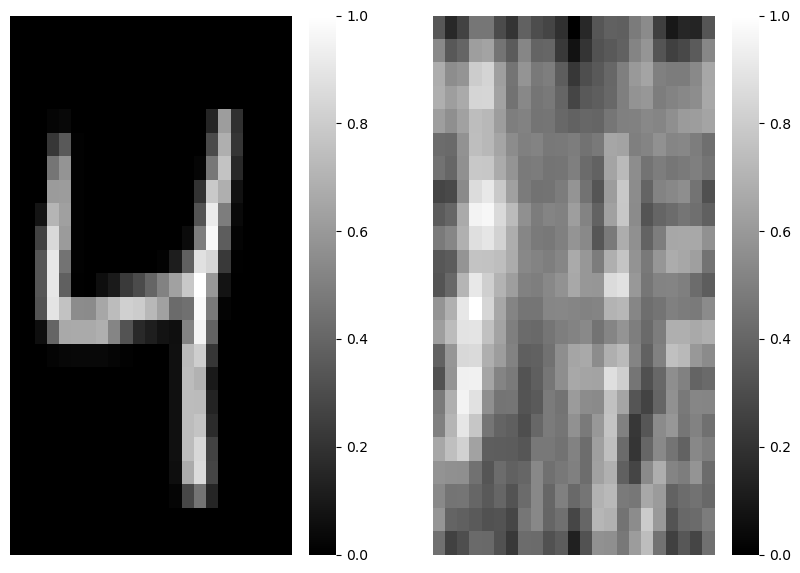

In [7]:
fig, axs = plt.subplots(1,2, figsize=(10,7))
idx=2
sns.heatmap(loaders['train'].dataset[idx]['target'].squeeze(0), cmap= 'gray', ax=axs[0])
sns.heatmap(loaders['train'].dataset[idx]['img'].squeeze(0), cmap= 'gray', ax=axs[1])
axs[0].axis('off')
axs[1].axis('off')
plt.show()

# Define Model

In [8]:
class RECON_CNN(torch.nn.Module):
    '''
    Define a model with only one convolutional layer, NO activation function, and NO bias
    '''
    def __init__(self, params):
        super().__init__() 
        
        # Define model basic info -- gets model/data parameters from dictionary params
        self.params = params
        self.img_size = self.params['image_size']
        self.kernel_size = self.params['image_size'] if self.params['image_size'] is not None else self.params['kernel_size']
        self.params["kernel_size"] = self.kernel_size
        self.criterion = torch.nn.MSELoss() if self.params.get('loss') is None else torch.nn.L1Loss() #
        self.params['model_save_path'] = f'../models/learned_decoder_cnn/{params["model"]}.pth'
        # if os.path.exists(self.params["model_save_path"]):
        #     self.load_state_dict(torch.load(self.params["model_save_path"]))
        #     print("Weights loaded from {}".format(self.params["model_save_path"]))
        
        # Define model architecture elements
        # Padding is circular -- mathematical motivation
        self.conv  = torch.nn.Conv2d(1,1,kernel_size=self.kernel_size, padding='same', padding_mode='circular', bias=False)#(self.kernel_size-1)//2)
        print("Using the following parameters:")
        for key, val in self.params.items():
            print(f"{key}: {val}")
        
    def forward(self, x):
        output = self.conv(x)
        return output

In [9]:
# Instantiate model 
model = RECON_CNN(params)#.to(device)
model.optimizer = torch.optim.Adam(model.parameters(), lr = model.params['learning_rate'])
model.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(model.optimizer, 'min',patience=model.params['scheduler_patience'])

RUN_DIR = path+f'runs/{model.params["model"]}/'
# LOAD MODEL
# model.load_state_dict(torch.load('../models/learned_decoder_cnn/decoder_cnn.pth'))
model.load_state_dict(torch.load(RUN_DIR+f"{model.params['model']}.pth"))

Using the following parameters:
image_size: 23
batch_size: 100
learning_rate: 0.001
epochs: 10
model: decoder_cnn_2024-01-11
dataset: mnist_mura_noiseless
scheduler_patience: 2
snr: None
kernel_size: 23
model_save_path: ../models/learned_decoder_cnn/decoder_cnn_2024-01-11.pth


<All keys matched successfully>

In [10]:
# Count total number of parameters in model
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 529


In [13]:
%%time
# Initialize project in Weights and Biases
wandb.init(config=wandb.config, 
           project="ca-learned-decoder", 
           group="cnn", 
           name=str(datetime.datetime.now()))

# Store values for later 
train_loss = []
frob_per_epoch = []
weights_epoch = {}

#Dictionary that will store different images and outputs for various epochs (not sure if needed)
outputs = {}

# Training loop starts
for epoch in range(params['epochs']):
    
    # Initialize variable to store loss
    running_loss = 0
    model.train()
    # Iterate over training set
    for i, data in enumerate(loaders['train']):
        # zero the parameter gradients
        model.optimizer.zero_grad()
        
        # get the inputs; data is a dict of [images, labels, digit]
        inputs, targets, digits = data['img'], data['target'], data['digit']
            
        # Generate output
        out = model(inputs)
        
        # Calculate loss
        loss = model.criterion(out, targets)
        
        # # Modified (04/06/23) to include l_1 penalty
        # l_1_pen = sum((w.abs()-1).abs().sum() for w in model.parameters())
        # loss = loss + (model.params['lambda']/(model.params['p']**2)) * l_1_pen

        
        # Backprop and update weights
        loss.backward()
        model.optimizer.step()
        
        # Increment loss
        running_loss += loss.item()
        
    
    # Average loss over entire dataset
    running_loss/= len(loaders['train'].dataset)#params['batch_size']
    train_loss.append(running_loss)

    # Scheduler step every epoch
    model.scheduler.step(loss)
    
    print(f"Epoch {epoch +1} | Loss: {running_loss:.7f}")
    wandb.log({"epoch": epoch, "loss": running_loss, }) 
    
    # Storing images, reconstructed outputs, and labels
    outputs[epoch+1] = {'img': inputs, 'out': out, 'targets': targets, 'digits': digits}
    
    # Save weights every 10 epochs
    if epoch % 2 == 1:
        torch.save(model.state_dict(), model.params['model_save_path'])
        # epoch_save_model = path+f'models/CNN/{params["model"]}_model_epoch_'+str(epoch)+'.pth'
        # torch.save(model.state_dict(),epoch_save_model)
        weight_epoch_list = list(model.parameters())
        weights_epoch[f'{epoch}'] = np.squeeze(weight_epoch_list[0].detach().cpu().numpy())
        

    # Calculate Frobenius norm between weights and decoder every epoch
    weights = list(model.parameters())
    weight_map = np.squeeze(weights[0].detach().cpu().numpy())
    diff_block = mnist_mura.G - weight_map
    frob_per_epoch.append(np.linalg.norm(np.abs(diff_block),ord='fro'))

#torch.save(model.state_dict(), PATH)
# End WandB run
wandb.finish()

Epoch 1 | Loss: 0.0074329
Epoch 2 | Loss: 0.0068022
Epoch 3 | Loss: 0.0067733
Epoch 4 | Loss: 0.0067637
Epoch 5 | Loss: 0.0067594
Epoch 6 | Loss: 0.0067571
Epoch 7 | Loss: 0.0067558
Epoch 8 | Loss: 0.0067550
Epoch 9 | Loss: 0.0067545
Epoch 10 | Loss: 0.0067541


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▁▁▁▁▁▁▁▁▁
epoch,9
loss,0.00675


CPU times: user 4min 9s, sys: 58.3 s, total: 5min 7s
Wall time: 3min 58s


In [21]:
# Save model weights from last epoch
torch.save(model.state_dict(), RUN_DIR+f"{model.params['model']}.pth")

# Save weight progression
dict_path = RUN_DIR+'weights_epoch.pkl'

import pickle
# Save weights dictionary to file
with open(dict_path, 'wb') as pickle_file:
    pickle.dump(weights_epoch, pickle_file)
print(f'Dictionary saved to {dict_path}')

# save frobenius per epoch
with open(RUN_DIR+'frob_per_epoch.pkl', 'wb') as pickle_file:
    pickle.dump(frob_per_epoch, pickle_file)
print(f'Frobenius saved to {RUN_DIR+"frob_per_epoch.pkl"}')

Dictionary saved to /Users/jornelasmunoz/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/runs/decoder_cnn_2024-01-11/weights_epoch.pkl


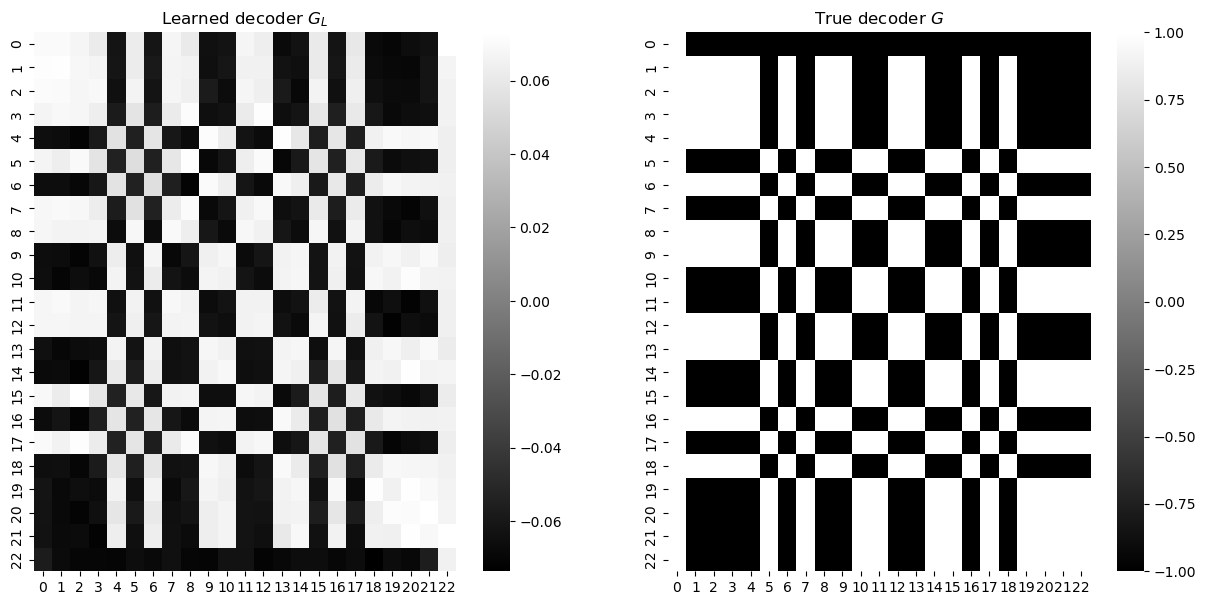

In [12]:
# Pot weights
weight_map = list(model.parameters())[0].cpu().detach().squeeze(0).squeeze(0)
fig, axs = plt.subplots(1,2, figsize = (15,7))
sns.heatmap(weight_map, cmap='gray', ax=axs[0])
sns.heatmap(mnist_mura.G, cmap='gray', ax=axs[1])

axs[0].set_title("Learned decoder $G_L$")
axs[1].set_title("True decoder $G$")
# fig.savefig('../figs/learned_decoder_cnn_20_epochs_circular_pad.png')

plt.show()

# Test set evaluation

In [37]:
from torchmetrics.image import StructuralSimilarityIndexMeasure 

In [38]:
SSIM = StructuralSimilarityIndexMeasure()

In [39]:
# This is to load test sets with different levels of noise. Change level of noise
model.params['snr'] = 10

# Define transforms 
train_transform_list =[transforms.Grayscale(),
                       transforms.ToTensor(),
                       transforms.Resize(params['image_size'], antialias=True), 
                      ]
# For noiseless data, just normalize values between [0,1]
# If noise, add desired SNR noise
if model.params.get('snr') is None: 
    train_transform_list.append(Normalize_01())
else:
    train_transform_list.append(Noise_dB(desired_snr=model.params['snr']))
    train_transform_list.append(Normalize_01())

train_transform = transforms.Compose(train_transform_list)
target_transform = transforms.Compose(
            [   transforms.Grayscale(),
                transforms.ToTensor(),
                transforms.Resize((params['image_size'],params['image_size']), antialias=True),
                Normalize_01(),
                ])

# Define test set
test_mnist_mura = MNIST_MURA('../data/MNIST/', params, transform=train_transform, target_transform=target_transform, train=False)
testset = DataLoader(test_mnist_mura, batch_size=10, shuffle=True)

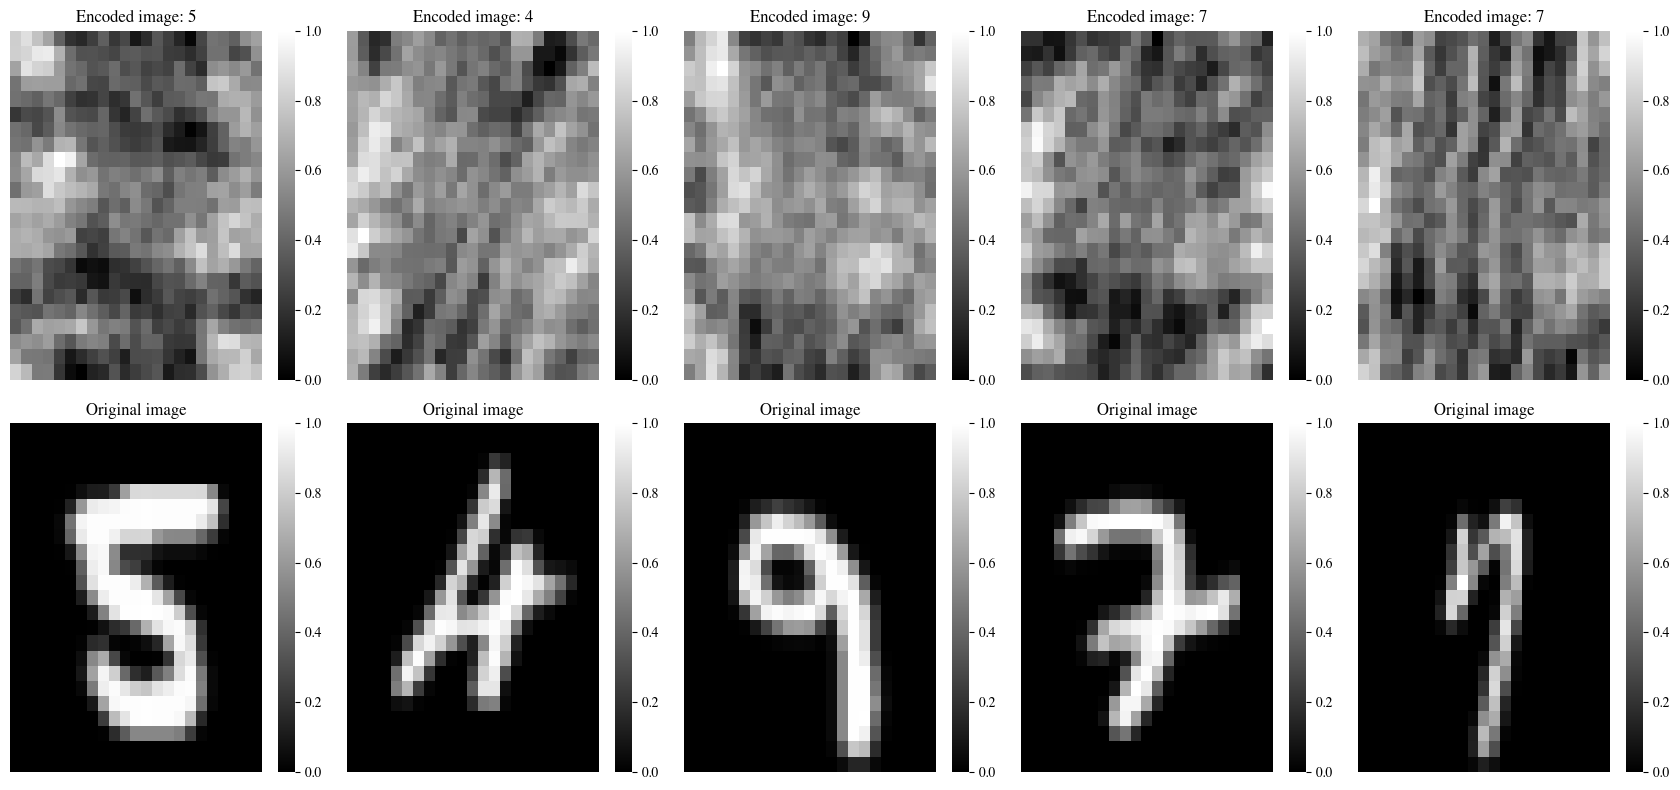

In [40]:
# Change plotting parameters
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "Times", #"Computer Modern Serif"
    "figure.figsize" : [17,8],
})
# Printing 25 random images from the test dataset
random_samples = np.random.randint(1, len(testset), (5))
count = 0
for idx in random_samples: #range(random_samples.shape[0]):
    plt.subplot(2, 5, count + 1)
    sns.heatmap(testset.dataset[idx]['img'].squeeze(0), cmap='gray')
    plt.title(f'Encoded image: {testset.dataset[idx]["digit"]}')
    plt.axis('off')
    plt.subplot(2, 5, count + 6)
    sns.heatmap(testset.dataset[idx]['target'].squeeze(0), cmap='gray')
    plt.title('Original image')
    plt.axis('off')
    
    count += 1
plt.tight_layout()
plt.savefig(RUN_DIR+ f"encoded_examples_snr_{model.params['snr']}.png")
plt.show()

# Calculate results with model

In [42]:
# Save MSE and SSIM evaluations in list
results = []
for i, data in enumerate(testset):
    inputs, targets, digits = data['img'], data['target'], data['digit']
    outputs = model(inputs.to(device))
    mse_loss = model.criterion(outputs, targets)
    ssim_loss = SSIM(outputs, targets)
    results.append((inputs, outputs, targets, digits, mse_loss.item(), ssim_loss.item()))
    # show_outputs(outputs, targets, inputs, iterator=i)

,inputs,outputs,targets,digits,mse,ssim
0,"[[[tensor([0.7932, 0.6371, 0.3762, 0.3012, 0.2...","[[[tensor([ 1.0587e-01, 2.4814e-02, 8.2902e-...","[[[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,...","[tensor(5), tensor(4), tensor(2), tensor(1), t...",0.015218,0.804533
1,"[[[tensor([0.5828, 0.6831, 0.7847, 0.5497, 0.3...","[[[tensor([ 0.0060, 0.0111, 0.0754, 0.0383,...","[[[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,...","[tensor(8), tensor(8), tensor(2), tensor(0), t...",0.015793,0.781585
2,"[[[tensor([0.3799, 0.1951, 0.2818, 0.4955, 0.5...","[[[tensor([ 0.1213, 0.1458, 0.2082, 0.0935,...","[[[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,...","[tensor(7), tensor(9), tensor(4), tensor(0), t...",0.016183,0.819646
3,"[[[tensor([0.4661, 0.3888, 0.2840, 0.4016, 0.4...","[[[tensor([ 0.2732, 0.0140, 0.1982, 0.1730,...","[[[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,...","[tensor(4), tensor(9), tensor(7), tensor(4), t...",0.015817,0.811561
4,"[[[tensor([0.3300, 0.2394, 0.4487, 0.5554, 0.5...","[[[tensor([ 0.1126, 0.0218, 0.0405, 0.0768,...","[[[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,...","[tensor(2), tensor(8), tensor(1), tensor(2), t...",0.014448,0.825880


In [ ]:
# Put results in dataframe
df = pd.DataFrame(results, columns=['inputs', 'outputs', 'targets', 'digits', 'mse', 'ssim'])
df.head(5)

# Plot results

In [65]:
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
# pio.renderers.default = 'notebook'

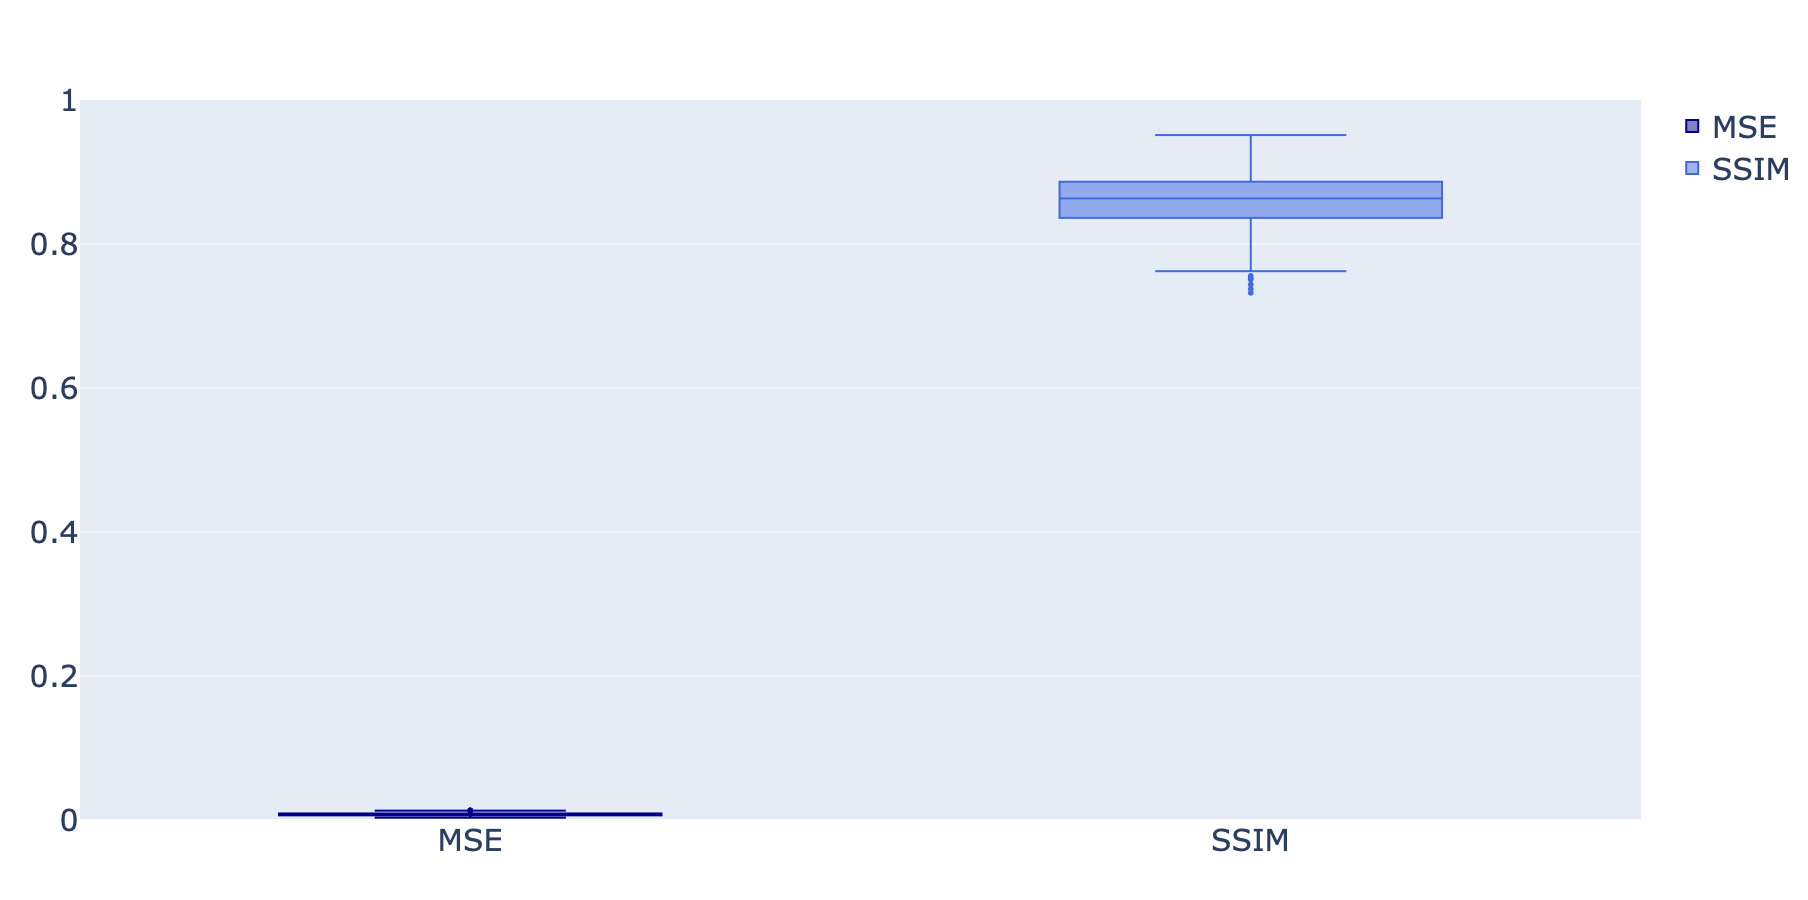

In [66]:
y0 = df.mse
y1 = df.ssim

fig = go.Figure()
fig.add_trace(go.Box(y=y0, name='MSE',
                marker_color = 'darkblue'))
fig.add_trace(go.Box(y=y1, name = 'SSIM',
                marker_color = 'royalblue'))
fig.update_layout(
    autosize=False,
    width=1200,
    height=900,
    yaxis=dict(
        # title_text="Y-axis Title",
        # ticktext=["Very long label", "long label", "3", "label"],
        # tickvals=,
        tickmode="array",
        titlefont=dict(size=30),
    ),
    yaxis_range=[0,1],
    font=dict(size=30),
)
fig.show(renderer="jupyterlab")
fig.write_image(RUN_DIR + f'boxplot_metrics_snr_{model.params["snr"]}.png')

# Deconvolution method

In [67]:
D = testset.dataset[0]['img']
fft_D = torch.fft.fft2(D.squeeze(0))
fft_A = torch.fft.fft2(torch.Tensor(mnist_mura.A))
invert = torch.fft.ifft2(fft_D/fft_A)
reflect = torch.roll(invert, [int((model.img_size-1)/2),int((model.img_size-1)/2)], dims=(0,1))

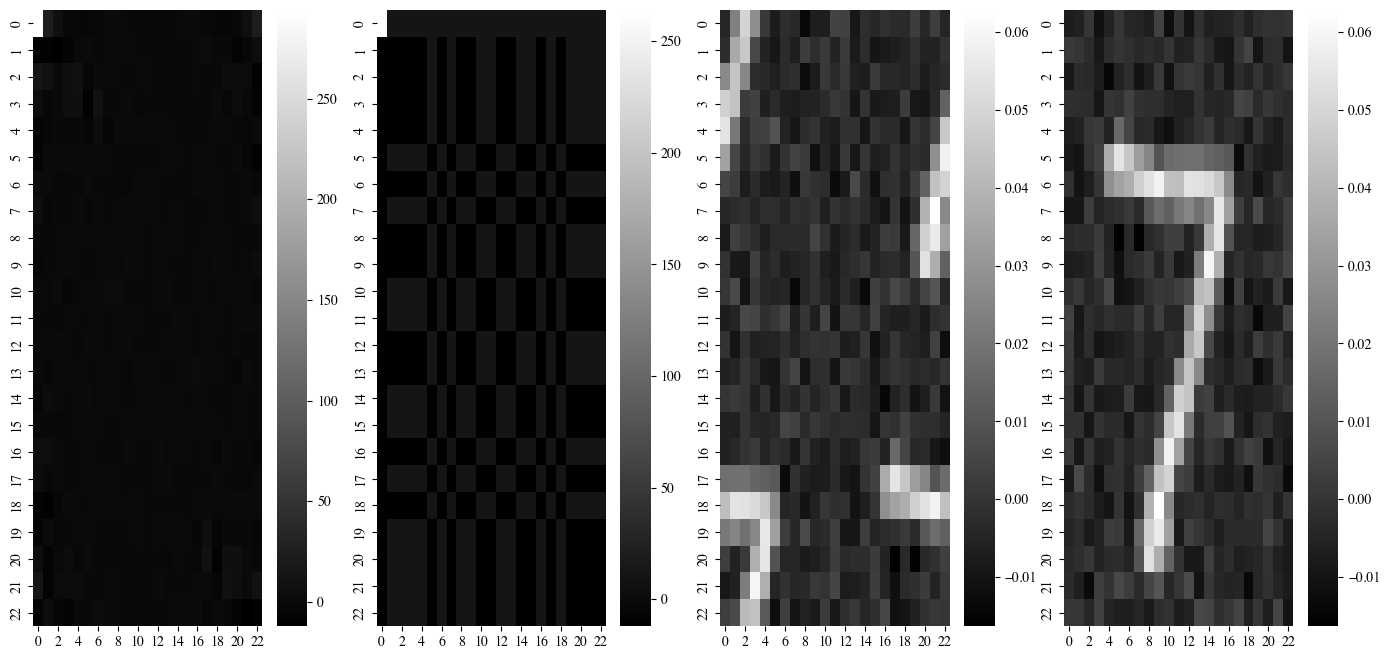

In [66]:
fig, axs = plt.subplots(1,4)
axs = axs.ravel()
sns.heatmap(fft_D.real, ax=axs[0], cmap='gray')
sns.heatmap(fft_A.real, ax=axs[1], cmap='gray')
sns.heatmap(invert.real, ax=axs[2], cmap='gray')
sns.heatmap(reflect.real, ax=axs[3], cmap='gray')
plt.show()

# Rotate the weights

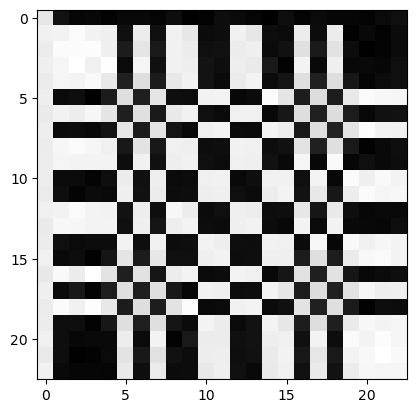

In [42]:
# Rotate the weights 180 degrees
w_rot90 = torch.rot90(torch.Tensor(weight_map), 1, [0, 1])
w_rot180 = torch.rot90(w_rot90, 1, [0, 1])
plt.imshow(w_rot180, cmap='gray')

In [28]:
padded_ex = torch.nn.functional.pad(loaders['train'].dataset[idx]['target'].unsqueeze(0), pad=(11,11,11,11), mode='circular')
padded_ex = padded_ex.squeeze(0).squeeze(0)

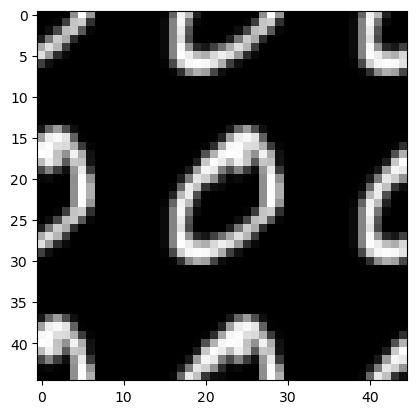

In [34]:
plt.imshow(padded_ex, cmap='gray')
plt.show()